## Getting started with readout error mitigation with Mitiq on Braket 

In this notebook, you will learn how to perform readout-error mitigation using [Mitiq](https://mitiq.readthedocs.io/en/stable/) with Amazon Braket program sets. This is particularly helpful for superconducting devices (IQM and Rigetti devices), which may contain larger measurement errors. 

### Installing Mitiq

>Mitiq is not included by default with `amazon-braket-examples` requirements or in the Amazon Braket Notebook Instances. To install, uncomment the first line in the next code block, and restart the notebook. Or run install from `extra/requirement-mitiq.txt`. 

Mitiq utilizes Cirq as the backend, and may represent circuits using their representation. 

In [1]:
# %pip install mitiq cirq-ionq
try:
    import mitiq  # noqa: F401
    print("Package 'mitiq' is installed.")
except ImportError:
    print("!! Package 'mitiq' is not installed !!")

Package 'mitiq' is installed.


In [2]:
import os
import sys

import numpy as np

from braket.circuits import Circuit

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), os.pardir))) # get parent directory tools  

from tools.mitigation_tools import apply_readout_twirl
from tools.noise_models import qd_readout as qd
from tools.noise_models import qd_readout_2 as qd2

np.set_printoptions(linewidth=500, precision=3, suppress=True)

### Readout error mitigation

Readout errors occur largely due to challenges in performing projective or POVM measurements on a device, which heavily depend on the hardware used and relevant physics and/or timescales. Readout error mitigation, or REM, specifically focuses on correcting these errors. Because of the ubiquity of the problem and the prevalance of superconducting devices, many schemes historically have focused on SC devices. However, different mitigation schemes may be better suited for device types, which some architectures having very high readout fidelities. 

Regardless of the device, within a static circuit (i.e. a traditional circuit model), we only have a single layer of measurements, and thus even largely high readout error rates can be permitted at the cost of a constant shot overhead. 

The most [common way](https://mitiq.readthedocs.io/en/stable/guide/rem-5-theory.html) of performing readout error mitigation is to (1) characterize the confusion matrix $C$ of relevant input state and output states, (2) calculate the inverse of this matrix, $C^{-1}$ and then (3) apply the inverse to your measurement results (which w.l.o.g. can be cast as an array) to obtain some error mitigated results. Each of these steps can involve some technical challenges at scale, which we detail below. The [mitiq REM](https://mitiq.readthedocs.io/en/stable/guide/rem.html) page contains numerous useful references related to REM. 

An optional step, which is utilized in Mitiq, is to (4) constrain the modified distribution to the closest probability distribution, using `scipy`.  

##### Note on post-selection

Post-selection is also a very common, physically motived error mitigation approach (also relevant to quantum error detection approaches, as in [McArdle et al.](https://arxiv.org/abs/1807.02467), [Cai et al.](https://arxiv.org/abs/2210.00921), [Sagastizabal](https://arxiv.org/abs/1902.11258)). We can equivalently cast $C$ as some projector $C_P$, where $P$ is a set of bit-strings that obey particle symmetries. $C$ is not invertible, but we can still consider it as a sort of filter applied to measurement results. Mitiq does [support post-selection](https://mitiq.readthedocs.io/en/stable/guide/rem-1-intro.html#apply-postselection) as well. 

#### Import the relevant Mitiq functions


In [3]:
from mitiq import MeasurementResult
from mitiq.rem import (
    generate_inverse_confusion_matrix,
    generate_tensored_inverse_confusion_matrix,
    post_select,
    rem_decorator,
)

#### Getting the confusion matrix

The confusion matrix can be obtained by preparing a complete set of input states and performing measurement in each basis. This in principle yields the following transition probabilities $C_{oi} = P(o | i)$, where $P(o | i)$ is the conditional probabilities of measuring a state $o$ when preparing $i$. For our purposes, we will have to learn our confusion matrix ourselves, so we do so here: 

In [4]:
num_qubits = 6

# UNCOMMENT_TO_RUN
# num_qubits = 2

dim = 2**num_qubits
results = []

for i in range(dim):
    circ = Circuit()
    bstr = f"{i:0{num_qubits}b}"

    for n,b in enumerate(bstr):
        circ.x(n) if b=="1" else circ.i(n)
    results.append(qd.run(circ.measure(range(num_qubits)),shots=10000).result().measurement_probabilities)

print(circ) # final state should be all X 

T  : │  0  │  1  │
      ┌───┐ ┌───┐ 
q0 : ─┤ X ├─┤ M ├─
      └───┘ └───┘ 
      ┌───┐ ┌───┐ 
q1 : ─┤ X ├─┤ M ├─
      └───┘ └───┘ 
      ┌───┐ ┌───┐ 
q2 : ─┤ X ├─┤ M ├─
      └───┘ └───┘ 
      ┌───┐ ┌───┐ 
q3 : ─┤ X ├─┤ M ├─
      └───┘ └───┘ 
      ┌───┐ ┌───┐ 
q4 : ─┤ X ├─┤ M ├─
      └───┘ └───┘ 
      ┌───┐ ┌───┐ 
q5 : ─┤ X ├─┤ M ├─
      └───┘ └───┘ 
T  : │  0  │  1  │


We then populate the confusion matrix in the variable `cm`, which is output below. 

In [5]:
cm = np.zeros((dim,dim))
for n,meas_results in enumerate(results):
    for k,v in meas_results.items():
        cm[int(k,2), n] = v


In [6]:
cm_i = generate_tensored_inverse_confusion_matrix(num_qubits, confusion_matrices=[cm])

Having the inverse confusion matrix, we can then apply this to our circuits.

In [7]:

circ = Circuit().h(0)
for i in range(0,num_qubits-1):
    circ.cnot(i,i+1)
circ.measure(range(num_qubits))
raw_results = []

@rem_decorator(inverse_confusion_matrix=cm_i)
def GHZ_rem(circ):
    counts = qd.run(circ, shots = 10000).result().measurement_counts
    raw_results.append(counts)
    return MeasurementResult.from_counts(counts)

res = GHZ_rem(circ).get_counts()

We can alternatively filter our results using post-selection.

In [8]:
def GHZ_raw(circ):
    counts = qd.run(circ, shots = 10000).result().measurement_counts
    raw_results.append(counts)
    return MeasurementResult.from_counts(counts)

ps_res = post_select(GHZ_raw(circ), lambda bits: all(bits) or all([not b for b in bits])).get_counts()
print(ps_res)

{'111111': 3619, '000000': 3690}


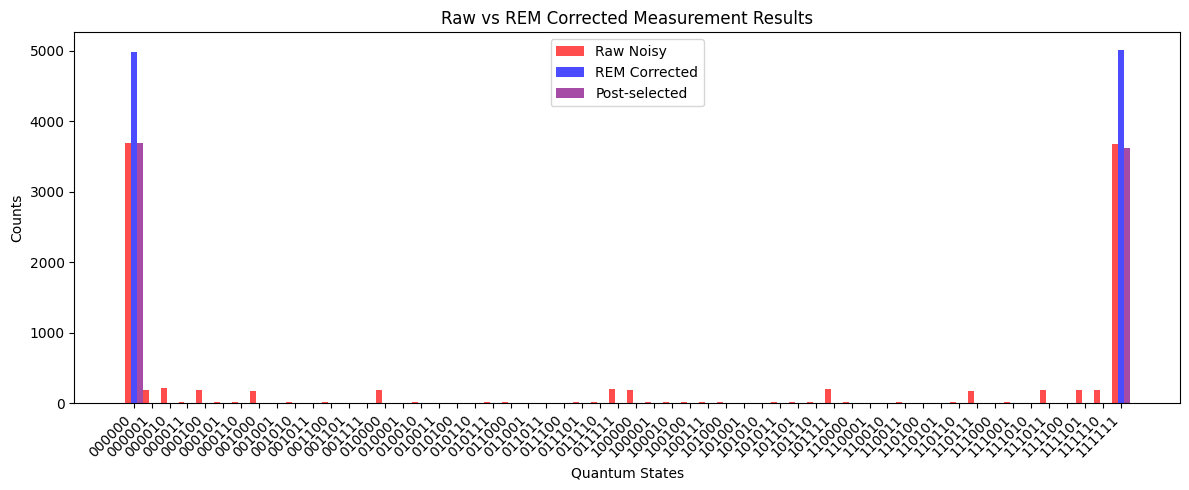

In [9]:
import matplotlib.pyplot as plt

raw_counts = raw_results[0]
corrected_counts = res

all_states = sorted(set(raw_counts.keys()) | set(corrected_counts.keys()))
raw_values = [raw_counts.get(state, 0) for state in all_states]
corr_values = [corrected_counts.get(state, 0) for state in all_states]
ps_values = [ps_res.get(state, 0) for state in all_states]


plt.figure(figsize=(12,5))
x = range(len(all_states))
width = 0.333
plt.bar([i - width for i in x], raw_values, width, label='Raw Noisy', color='red', alpha=0.7)
plt.bar([i  for i in x], corr_values, width, label='REM Corrected', color='blue', alpha=0.7)
plt.bar([i + width for i in x], ps_values, width, label='Post-selected', color='purple', alpha=0.7)
plt.xlabel('Quantum States')
plt.ylabel('Counts')
plt.title('Raw vs REM Corrected Measurement Results')
plt.xticks(x, all_states, rotation=45, ha='right')
plt.legend()
plt.tight_layout()
plt.show()

### Cost, accuracy, and efficiency of REM

Generally, a full characterization over $n-$qubits is only relevant when we expect correlated errors up to some degree $n$. Thus, often we can simplify the number of circuits we need (see [Bravyi et al.](https://arxiv.org/abs/2006.14044) for an example). However, these can potentially bias results if the states have not been averaged over the relevant subsystems, and their performance has some subtle effects. 

Here, we detail two additional features that we use to improve the above naive execution.

#### Characterization via program sets

The first task is to replace job submission with program sets. This allows us to submit many more circuits simultaneously. The above characterization circuits for instance, can be submitted with a single program set.

In [10]:
# let's get a 6-qubit local readout 
from braket.program_sets import ProgramSet

circuits = []
for i in range(dim):
    circ = Circuit()
    bstr = f"{i:0{num_qubits}b}"

    for n,b in enumerate(bstr):
        circ.x(n) if b=="1" else circ.i(n)

    circuits.append(circ.measure(range(6)))

pset = ProgramSet(circuits, shots_per_executable=10000)

result = qd.run(pset).result()
 


The result is to reducing queue times and service overhead time, as well as the total cost by \$0.32 * (64-1) ~ \$19, just from job submission. 

### Simplifying characterization with twirling 

We can further simplify the above procedure somewhat by considering a variant of the readout procedure. ***In brief***, we randomize the output measurement channel, and thus remove our input state dependence, reducing $2^n$ input states to 1. This is similar to ideas in [Hashim et al.](https://journals.aps.org/prxquantum/abstract/10.1103/PRXQuantum.6.010307), though [earlier works](https://journals.aps.org/pra/abstract/10.1103/PhysRevA.105.032620) have also used twirling in measurements. The main difference here is in the application of the inverse. 

The measurement POVM in the computational basis can be written as $M_i = \frac{1}{2}(I_i \pm Z_i)$. The measurement channel itself has the form $\mathcal{E}[\rho] = M_0 \rho M_0 + M_1 \rho M_1$. We can effectively "twirl" the measurement operation by inserting Pauli gates before (physically) and after (virtually). For a measurement channel, this will yield an effective bitflip channel.

The main difference here is the cost of learning - in a single configuration we can now learn all the symmetrized transition coefficients to precision $1/\sqrt{N}$. Another way to think of this is that most states have similar transition rates from 0 to 1 and 1 to 0. If we randomly flip these for all states, then we effectively average it out so that in expectation they are the same. 


#### Executing with Braket

We use a built-in function, `tools/apply_readout_twirl`, which generates the random twirled permutations and keeps track of the Pauli twirls associated it with. 

In [11]:

circuit = Circuit().z(0).z(1).z(2).z(3)

variants, paulis = apply_readout_twirl(circuit, num_samples = 5)

print(variants[-1])
print(paulis)


T  : │  0  │  1  │
      ┌───┐ ┌───┐ 
q0 : ─┤ Z ├─┤ Z ├─
      └───┘ └───┘ 
      ┌───┐ ┌───┐ 
q1 : ─┤ Z ├─┤ I ├─
      └───┘ └───┘ 
      ┌───┐ ┌───┐ 
q2 : ─┤ Z ├─┤ X ├─
      └───┘ └───┘ 
      ┌───┐ ┌───┐ 
q3 : ─┤ Z ├─┤ X ├─
      └───┘ └───┘ 
T  : │  0  │  1  │
('ZIZX', 'ZIXZ', 'YZYI', 'XXYI', 'ZIXX')


Now, let's see how performing twirls can standardize our distribution. We can look at $N_{twirls} = 10^m$ for $m \in \{0,1,2,3,4\}$. We can see that for $Z$ measurements, we can simply apply the Pauli as a bit mask using bit addition to get the intended measurement result. 

In [12]:
n_twirls = [1,10,100,1000,10000]

## UNCOMMENT_TO_RUN
# n_twirls = [1,10,]

circuit = Circuit()
for i in range(num_qubits):
    circuit.z(i)

distributions = []
for n in n_twirls:
    variants, masks  = apply_readout_twirl(circuit, n)
    variants = [v.measure(range(num_qubits)) for v in variants]
    masks = [''.join('1' if s in ["X","Y"] else '0' for s in m) for m in masks]

    pset = ProgramSet(variants, shots_per_executable= max(n_twirls)*10//n)
    results = qd2.run(pset).result()

    base = {}
    for item, mask in zip(results, masks):
        for k, v in item.entries[0].probabilities.items():
            kp = ''.join(str(int(a) ^ int(b)) for a, b in zip(k, mask))
            base[kp] = base.get(kp, 0) + v

    base = {k: v/n for k, v in base.items()}
    distributions.append(base)
    print(f"Distribution from twirling with {n} different measurement bases:")
    for m,(k,v) in enumerate(sorted(base.items(), key = lambda x : x[1],reverse=True)):
        print('  ',k,v)
        if m==5:
            break




Distribution from twirling with 1 different measurement bases:
   000000 0.66186
   001000 0.07561
   000001 0.06961
   100000 0.04109
   010000 0.03857
   000010 0.03465
Distribution from twirling with 10 different measurement bases:
   000000 0.6515700000000001
   100000 0.08131
   001000 0.05756
   000001 0.04860000000000001
   010000 0.04305
   000010 0.033909999999999996
Distribution from twirling with 100 different measurement bases:
   000000 0.66574
   100000 0.07069
   001000 0.05637000000000001
   000001 0.04888
   010000 0.043309999999999994
   000010 0.034109999999999974
Distribution from twirling with 1000 different measurement bases:
   000000 0.6633700000000005
   100000 0.07549000000000002
   001000 0.054750000000000035
   000001 0.04819000000000002
   010000 0.04328000000000001
   000010 0.03482999999999998
Distribution from twirling with 10000 different measurement bases:
   000000 0.6632400000000002
   100000 0.07380000000000532
   001000 0.05492000000000271
   00000

Now, taking the the largest number of twirls as the population mean, we can look at the distribution of errors for different $n$:

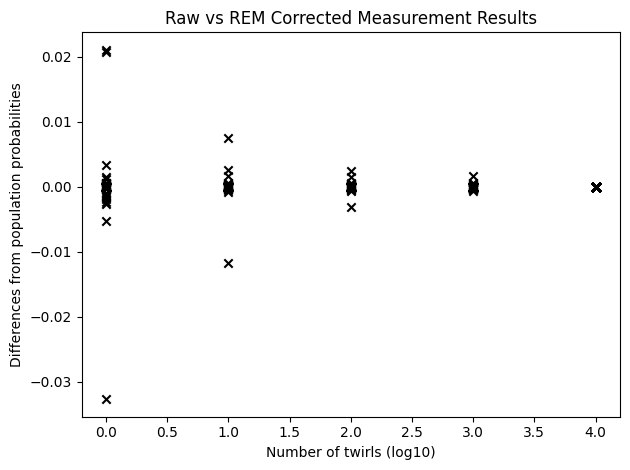

In [13]:
import matplotlib.pyplot as plt

raw_counts = raw_results[0]
corrected_counts = res

bars = [f"{k:0{num_qubits}b}" for k in range(dim)]

data = np.array([[distributions[i].get(state, 0) for state in bars] for i in range(len(distributions))])
data = data - data[-1,:] # broadcast the final entries 
data = data[:,:]
plt.figure()
for i in range(len(bars)):
    plt.scatter(range(len(distributions)), data[:,i], c= 'k', marker ='x')
plt.xlabel('Number of twirls (log10)')
plt.ylabel('Differences from population probabilities')
plt.title('Raw vs REM Corrected Measurement Results')
plt.tight_layout()
plt.show()

In [14]:
for i,n in enumerate(n_twirls[:-1]):    
    errors = data[:,i]
    print(f"errors (from largest result) across 10^{int(np.log10(n))} twirl(s): {np.average(errors):+.3f} +/- {np.std(errors):.3f}")

errors (from largest result) across 10^0 twirl(s): -0.002 +/- 0.005
errors (from largest result) across 10^1 twirl(s): +0.004 +/- 0.008
errors (from largest result) across 10^2 twirl(s): +0.000 +/- 0.000
errors (from largest result) across 10^3 twirl(s): +0.000 +/- 0.001


This distribution will look different for various noise models and realistic devices (in particular, symmetric noise would be a constant). Here we can see that the amplitude damping noise, which biases the measurement result towards a particular state, is effectively mitigated. 

When considering the precision, we see that even 10 twirls well approximate the mean, and at 100 twirls our standard deviations is below our expected sampling threshold of 0.001. 

#### Applying twirled results

Now, taking the 10 - 100 twirled result as our baseline, we can use this distribution to inform our noise model. Let's take 4096 shots with 64 twirls, targeting a noise precision of 0.016. 



In [15]:
total_shots = 4096
total_twirls = 64

circuit = Circuit()
for i in range(num_qubits):
    circuit.z(i)

distributions = []
variants, masks  = apply_readout_twirl(circuit, total_twirls)
masks = [''.join('1' if s in ["X","Y"] else '0' for s in m) for m in masks]
variants = [v.measure(range(num_qubits)) for v in variants]

# form program set

pset = ProgramSet(variants, shots_per_executable= total_shots//total_twirls)
results = qd2.run(pset).result()

base = {}
for item, mask in zip(results, masks):
    for k, v in item.entries[0].probabilities.items():
        kp = ''.join(str(int(a) ^ int(b)) for a, b in zip(k, mask))
        base[kp] = base.get(kp, 0) + v

# normalize
base = {k: v/total_twirls for k, v in base.items()}

distributions.append(base)
for n,(k,v) in enumerate(sorted(base.items(), key = lambda x : x[1],reverse=True)):
    print('  ',k,v)
    if n==5:
        break


   000000 0.659912109375
   100000 0.080322265625
   001000 0.064697265625
   000001 0.04833984375
   010000 0.036376953125
   000010 0.03076171875


From this distribution, we can obtain marginal distributions by summing over bitstrings. The relevant marginals we are interested are the single qubit bit flip probabilities. 
We can calculate these, and then convert them to a inverse distribution using mitiq. 

In [16]:
from functools import reduce

qubit_tallies = [0]*num_qubits
for i in range(num_qubits):
    for k,v in base.items():
        if k[i] == '1':
            qubit_tallies[i] += v

mats = [generate_inverse_confusion_matrix(1,p0=i,p1=i) for i in qubit_tallies]
print("Average single qubit bit flip rates")
print(qubit_tallies)
mat = reduce(np.kron, mats, np.array([[1]]))

Average single qubit bit flip rates
[0.107666015625, 0.055419921875, 0.087158203125, 0.036376953125, 0.045166015625, 0.067138671875]


#### On the variance of measurement inversion and post-selection

REM techniques generally affect the variance of the output distribution. This is essentially because the inverse matrix has a norm larger than the identity, i.e. you are expanding some contractive stochastic mapping. From [previous work](https://arxiv.org/pdf/2006.14044), we can see that the variance for a tensor product of single qubit probabilities increases the variance by:

$$ \gamma =  \prod_{j=1}^n \frac{1}{1 - 2 p_j}$$

where $p_j$ is the effective bitflip error rate.

Below, we calculate the $\gamma$ factor for our above single bit-flip model. This implies that we need to increase our shots by a factor of $\gamma^2$ to decrease the precision by $\gamma$.  

In [17]:
gamma = reduce(lambda x,y: x*y,[1/ (1- 2*p_i) for p_i in qubit_tallies], 1)

print(f"gamma factor: {gamma}")

gamma factor: 2.37718909008966


Under the method here, with some assumptions, we find that generally if we learn the probabilities $p_i$ to precision $1/\sqrt{N}$, then we expect a bias in our result of $\frac{\gamma}{\sqrt{N}}$. The additional factor of $\gamma$ is due to the fact that it itself functionally depends on $\hat p_i$, and has a related propagation of error. Thus, to suppress this, we would ideally learn the noise with $\gamma^2 N$ shots. 

However, we can be optimistic as well. This is some what of a worst-case applied to a fully $n-$qubit observable which depend on all states. This can occur for non-local fermion-to-qubit mappings like Jordan-Wigner, but $k-$ local observables this is effectively mitigated. Note, bitstrings by comparison are fully $n-$local. For our local case, we can define a worst-case gamma,

$$ \gamma^*(O) = \max_{I \in O} \prod_{j \in I} \frac{1}{1 - 2 p_j} $$

where $I$ is a vector or set of indices corresponding to observables within $O$ we are measuring. Thus, a sufficient overhead is ${\gamma^*}^2$. 




### Summary

In this notebook we showed how we can perform readout error mitigation with Mitiq using Amazon Braket. We show standard characterization techniques, as well as a twirled variant which can be applied to distribution through the inverse confusion matrix. Interested readers are encouraged to visit the further references below and at the [Mitiq repository](https://mitiq.readthedocs.io/en/stable/guide/rem.html). 

### References 

1. Unitary Foundation, [**mitiq.rem documentation**](https://mitiq.readthedocs.io/en/stable/guide/rem.html). Accessed 12/9/2025. 
2. Bravyi et al., [**Mitigiating measurement errors in multi-qubit experiments**](https://arxiv.org/pdf/2006.14044) (2021) Phys. Rev. A., 103, 042605. 
3. Hashim et al., [**Quasiprobabilistic Readout Correction of Midcircuit Measurements for Adaptive Feedback via Measurement Randomized Compiling**](https://journals.aps.org/prxquantum/pdf/10.1103/PRXQuantum.6.010307) (2025) PRX Quantum, 6, 010307. 
4. Sagastizabal et al., [**Experimental error mitigation via symmetry verification in a variational quantum eigensolver**](https://journals.aps.org/pra/abstract/10.1103/PhysRevA.100.010302) 2019, Phys. Rev. A, 100, 010302. 